# Scheduling operations
In this notebook we will cover the QGym `Scheduling` environment.

This environment is aimed at finding the shortest possible schedules of operations defined by random quantum circuits, whilst taking hardware constraints and commutation rules into account.

In [9]:
%matplotlib inline
import numpy as np
import networkx as nx
from networkx.generators import fast_gnp_random_graph
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from IPython.display import clear_output

from qgym.custom_types import Gate
from qgym.envs.scheduling import Scheduling
from qgym.envs.scheduling.scheduling_rewarders import BasicRewarder, EpisodeRewarder

In [2]:
def render_rgb(step, rgb_array):
    clear_output(wait=True)
    plt.figure(figsize=(40, 20))
    plt.title(f"Step {step}", fontsize=40)
    plt.imshow(rgb_array)
    plt.axis("off")
    plt.show()

### Circuits

The scheduling problem consist of scheduling the operations described by quantum circuit. 
In this model a quantum circuit is defined as a list of gates, where a gate is a `namedtuple` with a `name`, `q1` and `q2`.
For example a c-not with control qubit 2 and target qubit 5 would be `Gate("cnot", 2, 5)` and a X gate acting on qubit 4 would be `Gate("x", 4, 4)`.
In this representation, the circuit below is given by `[Gate("x", 1,1), Gate("cnot", 1,0), Gate("x", 0,0), Gate("h", 1,1)]`.
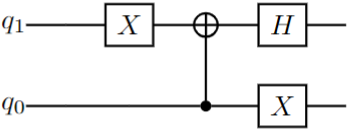


###  Hardware specifications

Different operations defined by a quantum circuit have different operation times, which are defined in the unit of machine cycles.
For example, a X gate could take 2 machine cycles, whereas a measurement could take 15 cycles.
These different operation times must be taken into account, because only one operation can be performed on a qubit at the same time.

Finding a optimal schedule with these restriction is already a difficult task.
However, to complicate matters there are also certain limitations defined by the hardware.
To be more concrete, we take two types of limitations into account:

1. Some gates must start at the same time, or must wait till the previous one is finished. This is typically the case for measurements.
2. Some gates can't be executed in the same cycle. This for example happens often with X, Y and Z gates.


The goal of this scheduling problem is to find an optimal schedule which takes these hardware limitations into account, as well as some optional commutation rules.

### Toy hardware

To explain this concept in more detail we start by defining a some toy hardware specifications.


In [3]:
hardware_spec = {
    "qubit_number": 2,
    "gates": {
        "x": 2,
        "y": 2,
        "cnot": 4,
        "measure": 10,
    },
    "machine_restrictions": {
        "same_start": {"measure"},
        "not_in_same_cycle": {"x": ["y"], "y": ["x"]},
    },
}

### `Scheduling` environment

The `Scheduling` environment can be initialized by providing:
- hardware specifications; and
- a maximum circuit length, measured in the total number of gates of the circuit.

In [4]:
env = Scheduling(hardware_spec, max_gates=5, random_circuit_mode="workshop")

#### State space
The state space is described by a dictionary with the following structure:

- `max_gates`: Maximum circuit length.
- `n_qubits`: Number of physical qubits.
- `gate_cycle_length`: Mapping of integer encoded gates and their respective cycle length.
- `same_start`: Set of integer encoded gates that should start in the same cycle.
- `not_in_same_cycle`: Mapping of integer encoded gates that can't start in the same cycle.
- `steps_done`: Number of steps done since the last reset.
- `cycle`: Cycle we are currently in.
- `busy`: Used internally for the hardware limitations.
- `dependencies`: Shows the first $n$ gates that must be scheduled before this gate.
- `encoded_circuit`: Integer encoded representation of the circuit to schedule.
- `gate_names`: Gate names of the encoded circuit.
- `acts_on`: q1 and q2 of each gate.
- `legal_actions`: Array of legal actions. If the value at index $i$ determines if gate number $i$ can be scheduled or not. This array is baded on the machine restrictions and commutation rules.

In [5]:
env.reset()
print(env._state)

{'max_gates': 5, 'n_qubits': 2, 'gate_cycle_length': {1: 2, 2: 2, 3: 4, 4: 10}, 'same_start': [4], 'not_in_same_cycle': {1: [2], 2: [1]}, 'steps_done': 0, 'cycle': 0, 'busy': array([0, 0]), 'excluded_gates': {}, 'exclude_in_next_cycle': set(), 'blocking_matrix': array([[False,  True,  True],
       [False, False,  True],
       [False, False, False]]), 'dependencies': array([[1, 2, 0, 0, 0]]), 'encoded_circuit': [Gate(name=1, q1=1, q2=1), Gate(name=3, q1=0, q2=1), Gate(name=3, q1=1, q2=0)], 'schedule': array([-1, -1, -1]), 'gate_names': array([1, 3, 3, 0, 0]), 'acts_on': array([[1, 0, 1, 0, 0],
       [1, 1, 0, 0, 0]]), 'legal_actions': array([False, False,  True, False, False])}


#### Observation space

Each element in the observation space is a dictionary with 2 entries:
- `gate_names`: Gate names of the encoded circuit.
- `acts_on`: q1 and q2 of each gate.
- `dependencies`: Shows the first $n$ gates that must be scheduled before this gate.
- `legal_actions`: List of legal actions. If the value at index  $i$  determines if gate number $i$ can be scheduled or not.

In [6]:
print(env.observation_space)
print()
print(env.reset())

Dict(acts_on:MultiDiscrete([3 3 3 3 3 3 3 3 3 3]), dependencies:MultiDiscrete([5 5 5 5 5]), gate_names:MultiDiscrete([5 5 5 5 5]), legal_actions:MultiBinary(5))

{'gate_names': array([3, 3, 2, 1, 2]), 'acts_on': array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0]), 'dependencies': array([1, 2, 3, 4, 0]), 'legal_actions': array([False, False, False, False,  True])}


#### Action space

Performing a quantum operation takes a certain amount of time, which will be measured in (machine) cycles.
Therefore, this environment  aims to produces a schedule in terms of cycles.
To do this, the  environment  schedules the circuit from right to left, so cycle zero in the schedule is the last operation to be performed in that schedule.
Based on this idea, a valid action is then a tuple of an integer $i\in\{0,1,\ldots,$ `max_gates`$\}$ and a binary value $j$.
The integer value $i$ schedules gate $i$ in the current cycle and the binary value $j$ increment the cycle number.

If the action is illegal (for example when we try to schedule a gate that has been scheduled already), then the environment will do nothing and the rewarder should give a penalty for this.

In [7]:
print(env.action_space)

MultiDiscrete([5 2])


#### Rewarders

We have pre-defined 2 different rewarders, which return a penalty when an illegal action is attempted, for a valid action their behavior is as follows:


- `BasicRewarder`: Every step gives a reward.
- `EpisodeRewarder`: Only the final step results in a reward.

Both rewarders can be tweaked by altering either of their parameters:

- `illegal_action_penalty`: penalty given for attempting an illegal action (should be non-positive)
- `update_cycle_penalty`: penalty given for incrementing the cycle (should be non-positive)
- `schedule_gate_bonus`: reward given for correctly scheduling a gate (should be non-negative)

<br/>
<br/>
<br/>
<br/>

### Reinforcement learning

Can we achieve useful schedules with reinforcement learning?

Does changing the rewarder and/or its parameter give better results?

In [17]:
env.rewarder = BasicRewarder(illegal_action_penalty=-5)
check_env(env, warn=True)

model = PPO("MultiInputPolicy", env, verbose=1)

model.learn(int(1e6))

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.3     |
|    ep_rew_mean     | -156     |
| time/              |          |
|    fps             | 970      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 29.3         |
|    ep_rew_mean          | -146         |
| time/                   |              |
|    fps                  | 743          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0071441056 |
|    clip_fraction        | 0.0199       |
|    clip_range           | 0.2          |
|    en

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 18.5        |
|    ep_rew_mean          | -92.4       |
| time/                   |             |
|    fps                  | 619         |
|    iterations           | 11          |
|    time_elapsed         | 36          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.005905996 |
|    clip_fraction        | 0.024       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.06       |
|    explained_variance   | 0.387       |
|    learning_rate        | 0.0003      |
|    loss                 | 368         |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00922    |
|    value_loss           | 875         |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 19.4

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | -59         |
| time/                   |             |
|    fps                  | 595         |
|    iterations           | 21          |
|    time_elapsed         | 72          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.008559646 |
|    clip_fraction        | 0.0805      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.54       |
|    explained_variance   | 0.768       |
|    learning_rate        | 0.0003      |
|    loss                 | 122         |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0179     |
|    value_loss           | 244         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.4  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.1        |
|    ep_rew_mean          | -60.5       |
| time/                   |             |
|    fps                  | 581         |
|    iterations           | 31          |
|    time_elapsed         | 109         |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.009004112 |
|    clip_fraction        | 0.0724      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.752       |
|    learning_rate        | 0.0003      |
|    loss                 | 91.8        |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0135     |
|    value_loss           | 171         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | -58.5       |
| time/                   |             |
|    fps                  | 575         |
|    iterations           | 41          |
|    time_elapsed         | 145         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.010392545 |
|    clip_fraction        | 0.0882      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.967      |
|    explained_variance   | 0.82        |
|    learning_rate        | 0.0003      |
|    loss                 | 56.9        |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.0147     |
|    value_loss           | 132         |
-----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | -55.1       |
| time/                   |             |
|    fps                  | 573         |
|    iterations           | 51          |
|    time_elapsed         | 182         |
|    total_timesteps      | 104448      |
| train/                  |             |
|    approx_kl            | 0.010083843 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.883      |
|    explained_variance   | 0.809       |
|    learning_rate        | 0.0003      |
|    loss                 | 44.6        |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.0165     |
|    value_loss           | 110         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.92  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | -55.4      |
| time/                   |            |
|    fps                  | 570        |
|    iterations           | 61         |
|    time_elapsed         | 218        |
|    total_timesteps      | 124928     |
| train/                  |            |
|    approx_kl            | 0.01386795 |
|    clip_fraction        | 0.126      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.801     |
|    explained_variance   | 0.837      |
|    learning_rate        | 0.0003     |
|    loss                 | 43.9       |
|    n_updates            | 600        |
|    policy_gradient_loss | -0.0184    |
|    value_loss           | 110        |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.73        |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | -57.6       |
| time/                   |             |
|    fps                  | 570         |
|    iterations           | 71          |
|    time_elapsed         | 254         |
|    total_timesteps      | 145408      |
| train/                  |             |
|    approx_kl            | 0.009271478 |
|    clip_fraction        | 0.0996      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.755      |
|    explained_variance   | 0.839       |
|    learning_rate        | 0.0003      |
|    loss                 | 68.6        |
|    n_updates            | 700         |
|    policy_gradient_loss | -0.0137     |
|    value_loss           | 113         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | -54.3       |
| time/                   |             |
|    fps                  | 566         |
|    iterations           | 81          |
|    time_elapsed         | 292         |
|    total_timesteps      | 165888      |
| train/                  |             |
|    approx_kl            | 0.010961704 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.697      |
|    explained_variance   | 0.832       |
|    learning_rate        | 0.0003      |
|    loss                 | 78.8        |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0133     |
|    value_loss           | 143         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | -59.3       |
| time/                   |             |
|    fps                  | 565         |
|    iterations           | 91          |
|    time_elapsed         | 329         |
|    total_timesteps      | 186368      |
| train/                  |             |
|    approx_kl            | 0.009474302 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.657      |
|    explained_variance   | 0.826       |
|    learning_rate        | 0.0003      |
|    loss                 | 68.6        |
|    n_updates            | 900         |
|    policy_gradient_loss | -0.0143     |
|    value_loss           | 118         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | -50.5       |
| time/                   |             |
|    fps                  | 564         |
|    iterations           | 101         |
|    time_elapsed         | 366         |
|    total_timesteps      | 206848      |
| train/                  |             |
|    approx_kl            | 0.009977968 |
|    clip_fraction        | 0.0971      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.608      |
|    explained_variance   | 0.827       |
|    learning_rate        | 0.0003      |
|    loss                 | 54.1        |
|    n_updates            | 1000        |
|    policy_gradient_loss | -0.0107     |
|    value_loss           | 111         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | -57.4       |
| time/                   |             |
|    fps                  | 563         |
|    iterations           | 111         |
|    time_elapsed         | 403         |
|    total_timesteps      | 227328      |
| train/                  |             |
|    approx_kl            | 0.010601081 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.611      |
|    explained_variance   | 0.876       |
|    learning_rate        | 0.0003      |
|    loss                 | 44.7        |
|    n_updates            | 1100        |
|    policy_gradient_loss | -0.0163     |
|    value_loss           | 93          |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.99  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | -56.2       |
| time/                   |             |
|    fps                  | 563         |
|    iterations           | 121         |
|    time_elapsed         | 439         |
|    total_timesteps      | 247808      |
| train/                  |             |
|    approx_kl            | 0.008932898 |
|    clip_fraction        | 0.0898      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.533      |
|    explained_variance   | 0.829       |
|    learning_rate        | 0.0003      |
|    loss                 | 50.2        |
|    n_updates            | 1200        |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 109         |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 12.4

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -49.1      |
| time/                   |            |
|    fps                  | 563        |
|    iterations           | 131        |
|    time_elapsed         | 476        |
|    total_timesteps      | 268288     |
| train/                  |            |
|    approx_kl            | 0.00833406 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.461     |
|    explained_variance   | 0.823      |
|    learning_rate        | 0.0003     |
|    loss                 | 64.4       |
|    n_updates            | 1300       |
|    policy_gradient_loss | -0.0141    |
|    value_loss           | 112        |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | -51.9       |
| time/                   |             |
|    fps                  | 562         |
|    iterations           | 141         |
|    time_elapsed         | 513         |
|    total_timesteps      | 288768      |
| train/                  |             |
|    approx_kl            | 0.010889834 |
|    clip_fraction        | 0.095       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.429      |
|    explained_variance   | 0.828       |
|    learning_rate        | 0.0003      |
|    loss                 | 81.6        |
|    n_updates            | 1400        |
|    policy_gradient_loss | -0.0121     |
|    value_loss           | 117         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11    

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.5         |
|    ep_rew_mean          | -50.8        |
| time/                   |              |
|    fps                  | 561          |
|    iterations           | 151          |
|    time_elapsed         | 550          |
|    total_timesteps      | 309248       |
| train/                  |              |
|    approx_kl            | 0.0081687225 |
|    clip_fraction        | 0.0702       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.4         |
|    explained_variance   | 0.851        |
|    learning_rate        | 0.0003       |
|    loss                 | 76.6         |
|    n_updates            | 1500         |
|    policy_gradient_loss | -0.00913     |
|    value_loss           | 110          |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | -54.4       |
| time/                   |             |
|    fps                  | 560         |
|    iterations           | 161         |
|    time_elapsed         | 587         |
|    total_timesteps      | 329728      |
| train/                  |             |
|    approx_kl            | 0.007339458 |
|    clip_fraction        | 0.07        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.406      |
|    explained_variance   | 0.845       |
|    learning_rate        | 0.0003      |
|    loss                 | 70.6        |
|    n_updates            | 1600        |
|    policy_gradient_loss | -0.0102     |
|    value_loss           | 131         |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2    

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.8         |
|    ep_rew_mean          | -53          |
| time/                   |              |
|    fps                  | 558          |
|    iterations           | 171          |
|    time_elapsed         | 626          |
|    total_timesteps      | 350208       |
| train/                  |              |
|    approx_kl            | 0.0075485655 |
|    clip_fraction        | 0.0801       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.379       |
|    explained_variance   | 0.854        |
|    learning_rate        | 0.0003       |
|    loss                 | 61.5         |
|    n_updates            | 1700         |
|    policy_gradient_loss | -0.0105      |
|    value_loss           | 92.6         |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | -54.9       |
| time/                   |             |
|    fps                  | 558         |
|    iterations           | 181         |
|    time_elapsed         | 663         |
|    total_timesteps      | 370688      |
| train/                  |             |
|    approx_kl            | 0.007730392 |
|    clip_fraction        | 0.0728      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.413      |
|    explained_variance   | 0.824       |
|    learning_rate        | 0.0003      |
|    loss                 | 49          |
|    n_updates            | 1800        |
|    policy_gradient_loss | -0.00877    |
|    value_loss           | 111         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | -52.1       |
| time/                   |             |
|    fps                  | 559         |
|    iterations           | 191         |
|    time_elapsed         | 698         |
|    total_timesteps      | 391168      |
| train/                  |             |
|    approx_kl            | 0.007775776 |
|    clip_fraction        | 0.072       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.392      |
|    explained_variance   | 0.829       |
|    learning_rate        | 0.0003      |
|    loss                 | 57.7        |
|    n_updates            | 1900        |
|    policy_gradient_loss | -0.0125     |
|    value_loss           | 121         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | -55.8       |
| time/                   |             |
|    fps                  | 560         |
|    iterations           | 201         |
|    time_elapsed         | 734         |
|    total_timesteps      | 411648      |
| train/                  |             |
|    approx_kl            | 0.007995274 |
|    clip_fraction        | 0.069       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.364      |
|    explained_variance   | 0.827       |
|    learning_rate        | 0.0003      |
|    loss                 | 82.4        |
|    n_updates            | 2000        |
|    policy_gradient_loss | -0.00863    |
|    value_loss           | 118         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | -53.7       |
| time/                   |             |
|    fps                  | 560         |
|    iterations           | 211         |
|    time_elapsed         | 771         |
|    total_timesteps      | 432128      |
| train/                  |             |
|    approx_kl            | 0.009265164 |
|    clip_fraction        | 0.0849      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.349      |
|    explained_variance   | 0.833       |
|    learning_rate        | 0.0003      |
|    loss                 | 76.2        |
|    n_updates            | 2100        |
|    policy_gradient_loss | -0.0103     |
|    value_loss           | 114         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | -55.2       |
| time/                   |             |
|    fps                  | 560         |
|    iterations           | 221         |
|    time_elapsed         | 807         |
|    total_timesteps      | 452608      |
| train/                  |             |
|    approx_kl            | 0.008067836 |
|    clip_fraction        | 0.0705      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.32       |
|    explained_variance   | 0.848       |
|    learning_rate        | 0.0003      |
|    loss                 | 111         |
|    n_updates            | 2200        |
|    policy_gradient_loss | -0.00964    |
|    value_loss           | 108         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | -49         |
| time/                   |             |
|    fps                  | 560         |
|    iterations           | 231         |
|    time_elapsed         | 843         |
|    total_timesteps      | 473088      |
| train/                  |             |
|    approx_kl            | 0.010906443 |
|    clip_fraction        | 0.0831      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.304      |
|    explained_variance   | 0.846       |
|    learning_rate        | 0.0003      |
|    loss                 | 64.7        |
|    n_updates            | 2300        |
|    policy_gradient_loss | -0.00933    |
|    value_loss           | 104         |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.3

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | -55.3       |
| time/                   |             |
|    fps                  | 561         |
|    iterations           | 241         |
|    time_elapsed         | 879         |
|    total_timesteps      | 493568      |
| train/                  |             |
|    approx_kl            | 0.007859105 |
|    clip_fraction        | 0.0648      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.312      |
|    explained_variance   | 0.842       |
|    learning_rate        | 0.0003      |
|    loss                 | 52.8        |
|    n_updates            | 2400        |
|    policy_gradient_loss | -0.00644    |
|    value_loss           | 100         |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.5

Let's give it the circuit below and see what kind of schedule the agent produces.

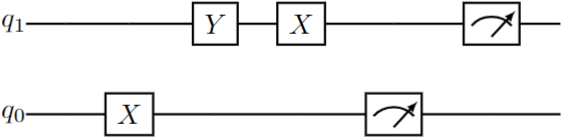

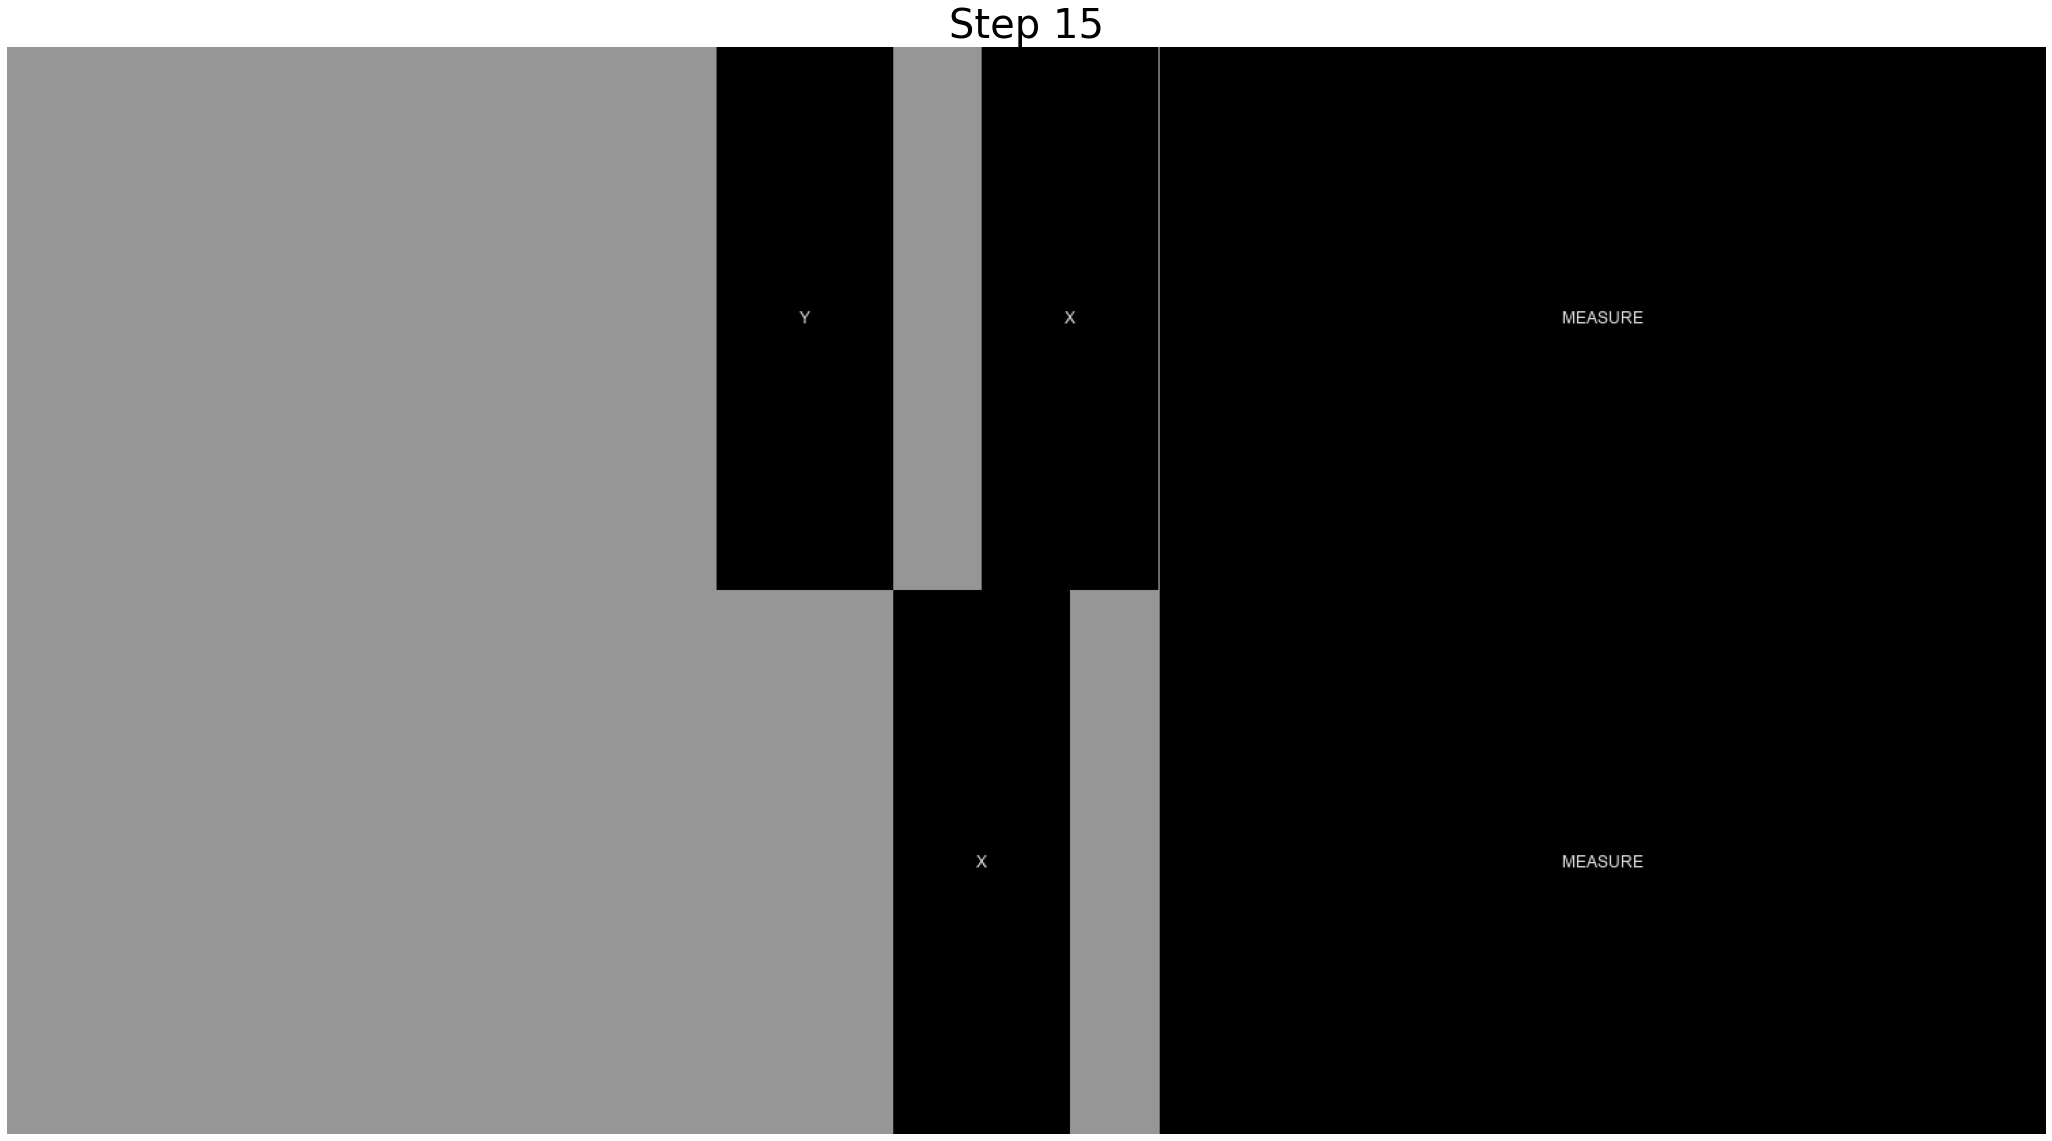

In [26]:
circuit = [Gate("x", 0, 0), Gate("y", 1, 1), Gate("x", 1, 1), Gate("measure", 0, 0), Gate("measure", 1, 1)] 
obs = env.reset(circuit = circuit)
for i in range(1000):
    action, states = model.predict(obs, deterministic=False)
    obs, rewards, done, info = env.step(action)
    render_rgb(i, env.render(mode="rgb_array"))
    if done:
        break

Let's also try some randomly generated circuits.

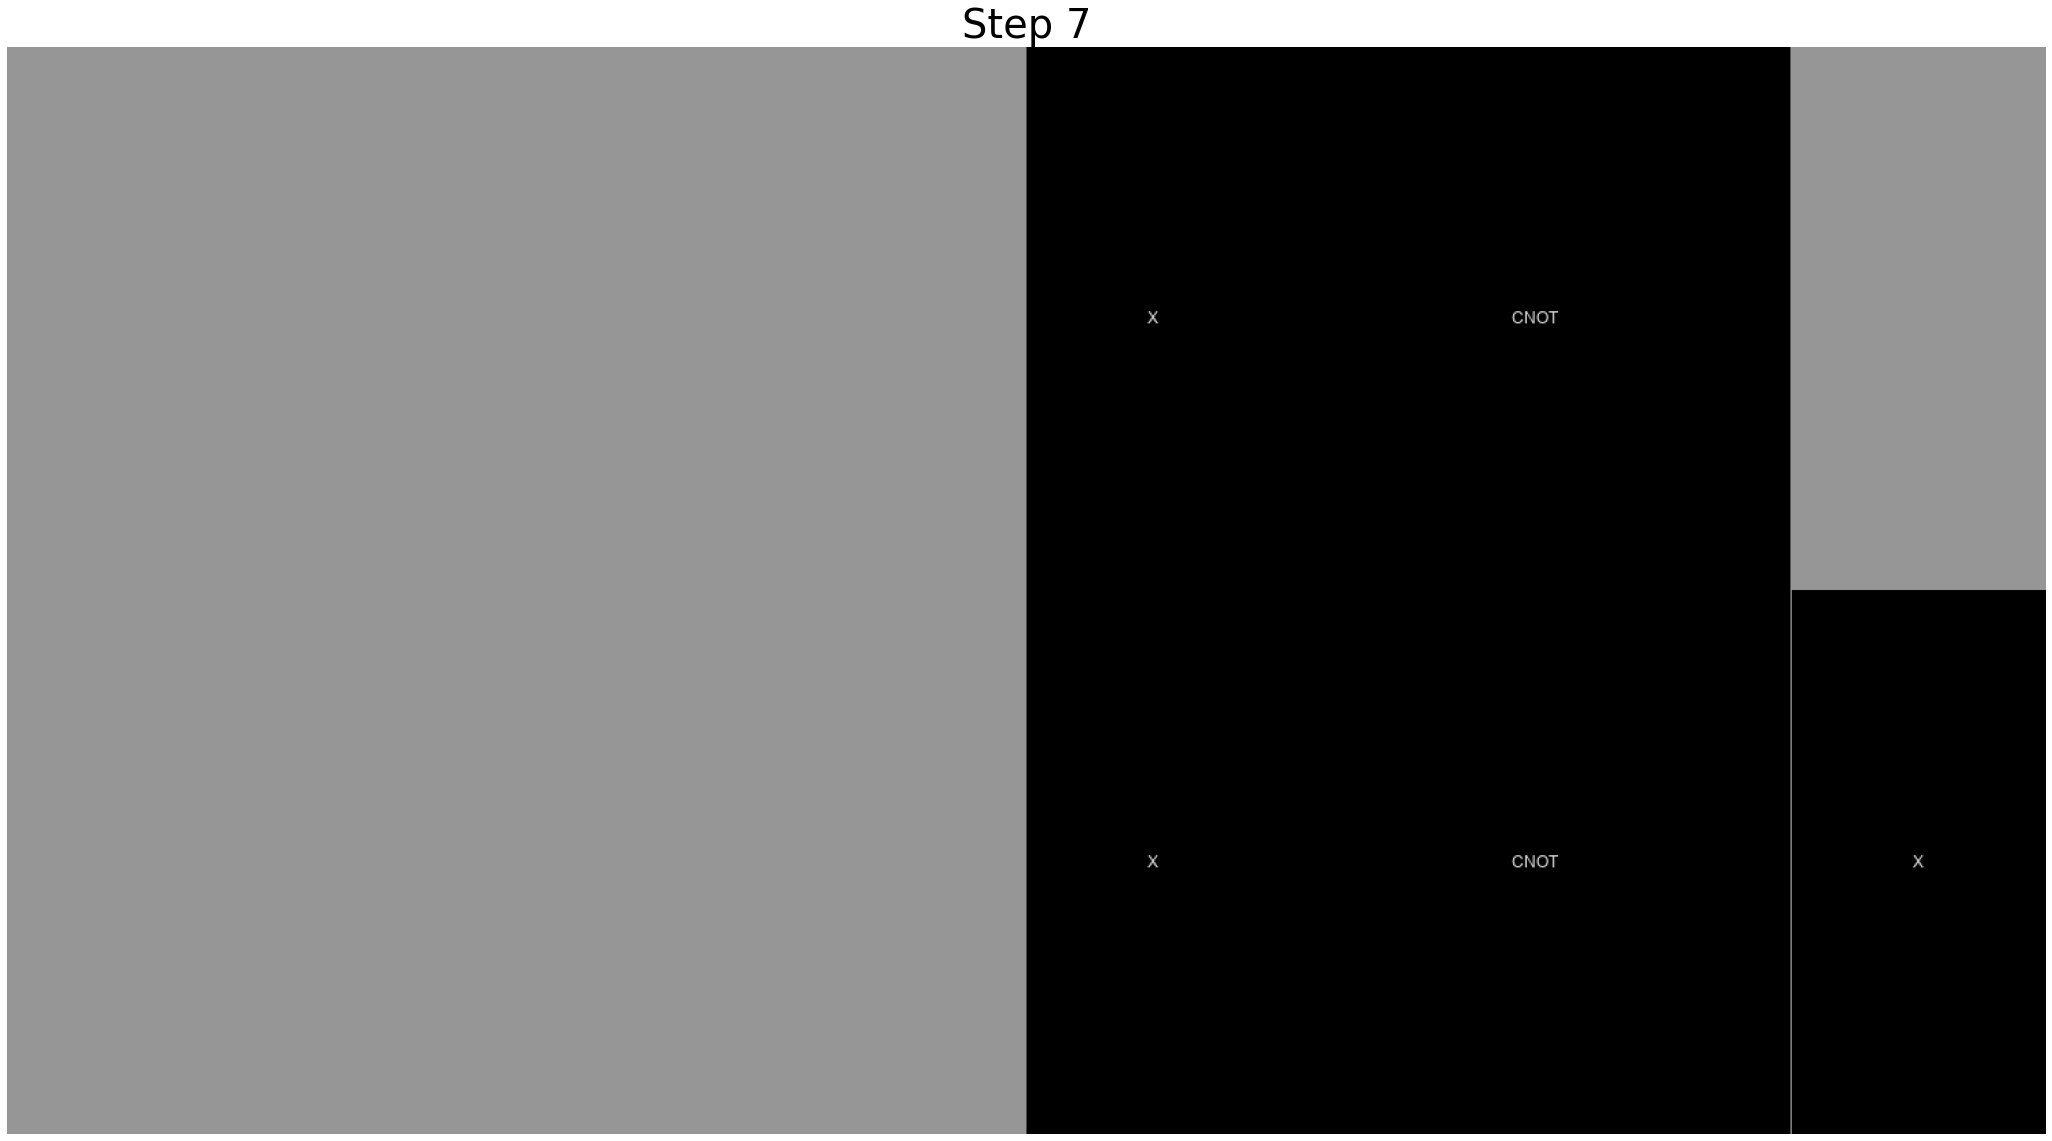

In [25]:
obs = env.reset()
for i in range(1000):
    action, states = model.predict(obs, deterministic=False)
    obs, rewards, done, info = env.step(action)
    render_rgb(i, env.render(mode="rgb_array"))
    if done:
        break

### Commutation Rules
While taking machine properties into account already makes the scheduling problem very difficult to solve.
However, the resulting schedules still don't provide a true optimal schedule.
To do this, commutation rules must be taken into account.
Under the hood of this environment, two very basic 'commutation rules' are already taken into account:
1. If two gates are exactly equal (same gate, same control qubit and same target qubit), then they commute.
2. If two gates don't have any qubits in common (the gates are disjoint), then they commute.

However, it is possible to extend the logic of the commutation rules by providing a custom commutation `CommutationRulebook` when initializing the environment.
By default, the `Rulebook` already takes into account the two rules above, but can be set to also take more rules into account.
To do this, we must provide a `callable` (function) which takes as input two gates and as output a Boolean value.

Let's try to implement the following commutation rule:
 - A c-not gate and a X gate commute if the X gates acts on the same qubit as the target of the c-not.
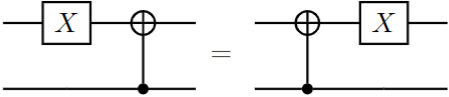



To start we import and initialize the `CommutationRulebook`

In [35]:
from qgym.envs.scheduling.rulebook import CommutationRulebook

rulebook = CommutationRulebook()

Next we make the rule and add it to the `CommutationRulebook`.
Remember that a gate is `namedtuple` with `name`, `q1` (control qubit) and `q2` (target qubit).

In [43]:
def cnot_x_commutation(gate1, gate2):
    if gate1.name == "cnot" and gate2.name == "x":
        if gate1.q2 ==  gate2.q1:
            return True
    
    if gate1.name == "x" and gate2.name == "cnot":
        if gate1.q1 ==  gate2.q2:
            return True
    
    return False

rulebook.add_rule(cnot_x_commutation)

Finally we add the `CommutationRulebook` to a new `Scheduling` environment and we train a new agent.

In [37]:
env_com = Scheduling(hardware_spec, max_gates=5, rulebook=rulebook, random_circuit_mode="workshop")

env_com.rewarder = BasicRewarder(illegal_action_penalty=-5)
check_env(env, warn=True)

model_com = PPO("MultiInputPolicy", env, verbose=1)

model_com.learn(int(1e6))

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.9     |
|    ep_rew_mean     | -150     |
| time/              |          |
|    fps             | 968      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28.8        |
|    ep_rew_mean          | -145        |
| time/                   |             |
|    fps                  | 750         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009258906 |
|    clip_fraction        | 0.0474      |
|    clip_range           | 0.2         |
|    entropy_loss   

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 18.2       |
|    ep_rew_mean          | -91.2      |
| time/                   |            |
|    fps                  | 617        |
|    iterations           | 11         |
|    time_elapsed         | 36         |
|    total_timesteps      | 22528      |
| train/                  |            |
|    approx_kl            | 0.00861858 |
|    clip_fraction        | 0.0553     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.02      |
|    explained_variance   | 0.445      |
|    learning_rate        | 0.0003     |
|    loss                 | 384        |
|    n_updates            | 100        |
|    policy_gradient_loss | -0.00932   |
|    value_loss           | 820        |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 18.1         |
|    ep_re

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2        |
|    ep_rew_mean          | -59.5       |
| time/                   |             |
|    fps                  | 596         |
|    iterations           | 21          |
|    time_elapsed         | 72          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.010068234 |
|    clip_fraction        | 0.0829      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.52       |
|    explained_variance   | 0.765       |
|    learning_rate        | 0.0003      |
|    loss                 | 122         |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0201     |
|    value_loss           | 241         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 14.6  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.1        |
|    ep_rew_mean          | -60         |
| time/                   |             |
|    fps                  | 592         |
|    iterations           | 31          |
|    time_elapsed         | 107         |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.008644221 |
|    clip_fraction        | 0.0854      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.12       |
|    explained_variance   | 0.797       |
|    learning_rate        | 0.0003      |
|    loss                 | 68.7        |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0163     |
|    value_loss           | 144         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -53.1      |
| time/                   |            |
|    fps                  | 589        |
|    iterations           | 41         |
|    time_elapsed         | 142        |
|    total_timesteps      | 83968      |
| train/                  |            |
|    approx_kl            | 0.00912305 |
|    clip_fraction        | 0.0979     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.935     |
|    explained_variance   | 0.784      |
|    learning_rate        | 0.0003     |
|    loss                 | 66.5       |
|    n_updates            | 400        |
|    policy_gradient_loss | -0.0165    |
|    value_loss           | 131        |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | -51.2       |
| time/                   |             |
|    fps                  | 587         |
|    iterations           | 51          |
|    time_elapsed         | 177         |
|    total_timesteps      | 104448      |
| train/                  |             |
|    approx_kl            | 0.009519527 |
|    clip_fraction        | 0.0954      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.771      |
|    explained_variance   | 0.828       |
|    learning_rate        | 0.0003      |
|    loss                 | 39          |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.0192     |
|    value_loss           | 126         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | -55.2       |
| time/                   |             |
|    fps                  | 585         |
|    iterations           | 61          |
|    time_elapsed         | 213         |
|    total_timesteps      | 124928      |
| train/                  |             |
|    approx_kl            | 0.008283077 |
|    clip_fraction        | 0.0909      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.684      |
|    explained_variance   | 0.812       |
|    learning_rate        | 0.0003      |
|    loss                 | 67          |
|    n_updates            | 600         |
|    policy_gradient_loss | -0.015      |
|    value_loss           | 118         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | -49.9       |
| time/                   |             |
|    fps                  | 585         |
|    iterations           | 71          |
|    time_elapsed         | 248         |
|    total_timesteps      | 145408      |
| train/                  |             |
|    approx_kl            | 0.010383969 |
|    clip_fraction        | 0.0927      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.623      |
|    explained_variance   | 0.829       |
|    learning_rate        | 0.0003      |
|    loss                 | 73.9        |
|    n_updates            | 700         |
|    policy_gradient_loss | -0.0148     |
|    value_loss           | 135         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | -58.8       |
| time/                   |             |
|    fps                  | 584         |
|    iterations           | 81          |
|    time_elapsed         | 283         |
|    total_timesteps      | 165888      |
| train/                  |             |
|    approx_kl            | 0.012261216 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.589      |
|    explained_variance   | 0.798       |
|    learning_rate        | 0.0003      |
|    loss                 | 84.8        |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0157     |
|    value_loss           | 126         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | -50.6       |
| time/                   |             |
|    fps                  | 584         |
|    iterations           | 91          |
|    time_elapsed         | 319         |
|    total_timesteps      | 186368      |
| train/                  |             |
|    approx_kl            | 0.007303541 |
|    clip_fraction        | 0.0815      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.541      |
|    explained_variance   | 0.816       |
|    learning_rate        | 0.0003      |
|    loss                 | 47.3        |
|    n_updates            | 900         |
|    policy_gradient_loss | -0.0115     |
|    value_loss           | 111         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | -57.1      |
| time/                   |            |
|    fps                  | 583        |
|    iterations           | 101        |
|    time_elapsed         | 354        |
|    total_timesteps      | 206848     |
| train/                  |            |
|    approx_kl            | 0.00810332 |
|    clip_fraction        | 0.0858     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.57      |
|    explained_variance   | 0.823      |
|    learning_rate        | 0.0003     |
|    loss                 | 51         |
|    n_updates            | 1000       |
|    policy_gradient_loss | -0.0127    |
|    value_loss           | 115        |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -50.5      |
| time/                   |            |
|    fps                  | 582        |
|    iterations           | 111        |
|    time_elapsed         | 390        |
|    total_timesteps      | 227328     |
| train/                  |            |
|    approx_kl            | 0.00824211 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.525     |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.0003     |
|    loss                 | 45.5       |
|    n_updates            | 1100       |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 111        |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | -55         |
| time/                   |             |
|    fps                  | 581         |
|    iterations           | 121         |
|    time_elapsed         | 425         |
|    total_timesteps      | 247808      |
| train/                  |             |
|    approx_kl            | 0.011309656 |
|    clip_fraction        | 0.0981      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.543      |
|    explained_variance   | 0.832       |
|    learning_rate        | 0.0003      |
|    loss                 | 51          |
|    n_updates            | 1200        |
|    policy_gradient_loss | -0.0123     |
|    value_loss           | 108         |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | -50.9       |
| time/                   |             |
|    fps                  | 581         |
|    iterations           | 131         |
|    time_elapsed         | 461         |
|    total_timesteps      | 268288      |
| train/                  |             |
|    approx_kl            | 0.009727187 |
|    clip_fraction        | 0.0932      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.481      |
|    explained_variance   | 0.853       |
|    learning_rate        | 0.0003      |
|    loss                 | 68.2        |
|    n_updates            | 1300        |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 108         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | -52.6       |
| time/                   |             |
|    fps                  | 580         |
|    iterations           | 141         |
|    time_elapsed         | 497         |
|    total_timesteps      | 288768      |
| train/                  |             |
|    approx_kl            | 0.010370996 |
|    clip_fraction        | 0.0935      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.468      |
|    explained_variance   | 0.836       |
|    learning_rate        | 0.0003      |
|    loss                 | 32.4        |
|    n_updates            | 1400        |
|    policy_gradient_loss | -0.0107     |
|    value_loss           | 102         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | -58.5       |
| time/                   |             |
|    fps                  | 579         |
|    iterations           | 151         |
|    time_elapsed         | 533         |
|    total_timesteps      | 309248      |
| train/                  |             |
|    approx_kl            | 0.007911121 |
|    clip_fraction        | 0.0746      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.414      |
|    explained_variance   | 0.825       |
|    learning_rate        | 0.0003      |
|    loss                 | 52.8        |
|    n_updates            | 1500        |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 127         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | -49.5       |
| time/                   |             |
|    fps                  | 579         |
|    iterations           | 161         |
|    time_elapsed         | 569         |
|    total_timesteps      | 329728      |
| train/                  |             |
|    approx_kl            | 0.007522532 |
|    clip_fraction        | 0.0721      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.409      |
|    explained_variance   | 0.838       |
|    learning_rate        | 0.0003      |
|    loss                 | 84.4        |
|    n_updates            | 1600        |
|    policy_gradient_loss | -0.011      |
|    value_loss           | 129         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | -50.7       |
| time/                   |             |
|    fps                  | 578         |
|    iterations           | 171         |
|    time_elapsed         | 605         |
|    total_timesteps      | 350208      |
| train/                  |             |
|    approx_kl            | 0.007916938 |
|    clip_fraction        | 0.0692      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.383      |
|    explained_variance   | 0.869       |
|    learning_rate        | 0.0003      |
|    loss                 | 40.7        |
|    n_updates            | 1700        |
|    policy_gradient_loss | -0.00926    |
|    value_loss           | 83.1        |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 12.4

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.3        |
|    ep_rew_mean          | -61.1       |
| time/                   |             |
|    fps                  | 578         |
|    iterations           | 181         |
|    time_elapsed         | 640         |
|    total_timesteps      | 370688      |
| train/                  |             |
|    approx_kl            | 0.007993328 |
|    clip_fraction        | 0.0748      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.409      |
|    explained_variance   | 0.806       |
|    learning_rate        | 0.0003      |
|    loss                 | 46.7        |
|    n_updates            | 1800        |
|    policy_gradient_loss | -0.0111     |
|    value_loss           | 112         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | -49.6       |
| time/                   |             |
|    fps                  | 578         |
|    iterations           | 191         |
|    time_elapsed         | 675         |
|    total_timesteps      | 391168      |
| train/                  |             |
|    approx_kl            | 0.008786716 |
|    clip_fraction        | 0.0917      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.42       |
|    explained_variance   | 0.841       |
|    learning_rate        | 0.0003      |
|    loss                 | 52          |
|    n_updates            | 1900        |
|    policy_gradient_loss | -0.0113     |
|    value_loss           | 100         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | -50.9       |
| time/                   |             |
|    fps                  | 578         |
|    iterations           | 201         |
|    time_elapsed         | 711         |
|    total_timesteps      | 411648      |
| train/                  |             |
|    approx_kl            | 0.009852175 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.391      |
|    explained_variance   | 0.775       |
|    learning_rate        | 0.0003      |
|    loss                 | 47.3        |
|    n_updates            | 2000        |
|    policy_gradient_loss | -0.0136     |
|    value_loss           | 114         |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.6

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | -53.5       |
| time/                   |             |
|    fps                  | 579         |
|    iterations           | 211         |
|    time_elapsed         | 746         |
|    total_timesteps      | 432128      |
| train/                  |             |
|    approx_kl            | 0.008930182 |
|    clip_fraction        | 0.0689      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.367      |
|    explained_variance   | 0.829       |
|    learning_rate        | 0.0003      |
|    loss                 | 36.8        |
|    n_updates            | 2100        |
|    policy_gradient_loss | -0.0108     |
|    value_loss           | 115         |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | -57         |
| time/                   |             |
|    fps                  | 579         |
|    iterations           | 221         |
|    time_elapsed         | 781         |
|    total_timesteps      | 452608      |
| train/                  |             |
|    approx_kl            | 0.007611996 |
|    clip_fraction        | 0.0792      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.337      |
|    explained_variance   | 0.86        |
|    learning_rate        | 0.0003      |
|    loss                 | 48.6        |
|    n_updates            | 2200        |
|    policy_gradient_loss | -0.0105     |
|    value_loss           | 88.8        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | -52.2       |
| time/                   |             |
|    fps                  | 579         |
|    iterations           | 231         |
|    time_elapsed         | 816         |
|    total_timesteps      | 473088      |
| train/                  |             |
|    approx_kl            | 0.007900379 |
|    clip_fraction        | 0.0611      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.318      |
|    explained_variance   | 0.85        |
|    learning_rate        | 0.0003      |
|    loss                 | 51.3        |
|    n_updates            | 2300        |
|    policy_gradient_loss | -0.00839    |
|    value_loss           | 108         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | -52.1       |
| time/                   |             |
|    fps                  | 579         |
|    iterations           | 241         |
|    time_elapsed         | 852         |
|    total_timesteps      | 493568      |
| train/                  |             |
|    approx_kl            | 0.008460188 |
|    clip_fraction        | 0.0673      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.337      |
|    explained_variance   | 0.822       |
|    learning_rate        | 0.0003      |
|    loss                 | 52.7        |
|    n_updates            | 2400        |
|    policy_gradient_loss | -0.0134     |
|    value_loss           | 134         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | -52.1       |
| time/                   |             |
|    fps                  | 579         |
|    iterations           | 251         |
|    time_elapsed         | 887         |
|    total_timesteps      | 514048      |
| train/                  |             |
|    approx_kl            | 0.009374272 |
|    clip_fraction        | 0.0815      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.314      |
|    explained_variance   | 0.851       |
|    learning_rate        | 0.0003      |
|    loss                 | 38          |
|    n_updates            | 2500        |
|    policy_gradient_loss | -0.0102     |
|    value_loss           | 99          |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | -57.1       |
| time/                   |             |
|    fps                  | 579         |
|    iterations           | 261         |
|    time_elapsed         | 922         |
|    total_timesteps      | 534528      |
| train/                  |             |
|    approx_kl            | 0.010783055 |
|    clip_fraction        | 0.0954      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.342      |
|    explained_variance   | 0.863       |
|    learning_rate        | 0.0003      |
|    loss                 | 40.3        |
|    n_updates            | 2600        |
|    policy_gradient_loss | -0.0121     |
|    value_loss           | 89.5        |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.8

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | -56.1      |
| time/                   |            |
|    fps                  | 579        |
|    iterations           | 271        |
|    time_elapsed         | 958        |
|    total_timesteps      | 555008     |
| train/                  |            |
|    approx_kl            | 0.00970863 |
|    clip_fraction        | 0.0879     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.325     |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.0003     |
|    loss                 | 68         |
|    n_updates            | 2700       |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 118        |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | -58.3       |
| time/                   |             |
|    fps                  | 579         |
|    iterations           | 281         |
|    time_elapsed         | 993         |
|    total_timesteps      | 575488      |
| train/                  |             |
|    approx_kl            | 0.007694818 |
|    clip_fraction        | 0.0744      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.311      |
|    explained_variance   | 0.815       |
|    learning_rate        | 0.0003      |
|    loss                 | 51.8        |
|    n_updates            | 2800        |
|    policy_gradient_loss | -0.00988    |
|    value_loss           | 111         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.4         |
|    ep_rew_mean          | -49.6        |
| time/                   |              |
|    fps                  | 579          |
|    iterations           | 291          |
|    time_elapsed         | 1028         |
|    total_timesteps      | 595968       |
| train/                  |              |
|    approx_kl            | 0.0064315903 |
|    clip_fraction        | 0.0635       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.263       |
|    explained_variance   | 0.854        |
|    learning_rate        | 0.0003       |
|    loss                 | 35.2         |
|    n_updates            | 2900         |
|    policy_gradient_loss | -0.00777     |
|    value_loss           | 102          |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | -56.6       |
| time/                   |             |
|    fps                  | 579         |
|    iterations           | 301         |
|    time_elapsed         | 1064        |
|    total_timesteps      | 616448      |
| train/                  |             |
|    approx_kl            | 0.007984849 |
|    clip_fraction        | 0.0606      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.255      |
|    explained_variance   | 0.841       |
|    learning_rate        | 0.0003      |
|    loss                 | 36.3        |
|    n_updates            | 3000        |
|    policy_gradient_loss | -0.00637    |
|    value_loss           | 100         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | -49         |
| time/                   |             |
|    fps                  | 579         |
|    iterations           | 311         |
|    time_elapsed         | 1099        |
|    total_timesteps      | 636928      |
| train/                  |             |
|    approx_kl            | 0.014781496 |
|    clip_fraction        | 0.0815      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.302      |
|    explained_variance   | 0.834       |
|    learning_rate        | 0.0003      |
|    loss                 | 61.3        |
|    n_updates            | 3100        |
|    policy_gradient_loss | -0.0144     |
|    value_loss           | 112         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.8         |
|    ep_rew_mean          | -52.1        |
| time/                   |              |
|    fps                  | 579          |
|    iterations           | 321          |
|    time_elapsed         | 1134         |
|    total_timesteps      | 657408       |
| train/                  |              |
|    approx_kl            | 0.0052250843 |
|    clip_fraction        | 0.0553       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.262       |
|    explained_variance   | 0.863        |
|    learning_rate        | 0.0003       |
|    loss                 | 41.4         |
|    n_updates            | 3200         |
|    policy_gradient_loss | -0.00557     |
|    value_loss           | 110          |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | -54.5       |
| time/                   |             |
|    fps                  | 579         |
|    iterations           | 331         |
|    time_elapsed         | 1170        |
|    total_timesteps      | 677888      |
| train/                  |             |
|    approx_kl            | 0.007513499 |
|    clip_fraction        | 0.067       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.272      |
|    explained_variance   | 0.84        |
|    learning_rate        | 0.0003      |
|    loss                 | 49.7        |
|    n_updates            | 3300        |
|    policy_gradient_loss | -0.00719    |
|    value_loss           | 107         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11           |
|    ep_rew_mean          | -52.7        |
| time/                   |              |
|    fps                  | 579          |
|    iterations           | 341          |
|    time_elapsed         | 1205         |
|    total_timesteps      | 698368       |
| train/                  |              |
|    approx_kl            | 0.0083149765 |
|    clip_fraction        | 0.0755       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.293       |
|    explained_variance   | 0.779        |
|    learning_rate        | 0.0003       |
|    loss                 | 49.5         |
|    n_updates            | 3400         |
|    policy_gradient_loss | -0.0135      |
|    value_loss           | 132          |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.1         |
|    ep_rew_mean          | -54.1        |
| time/                   |              |
|    fps                  | 578          |
|    iterations           | 351          |
|    time_elapsed         | 1242         |
|    total_timesteps      | 718848       |
| train/                  |              |
|    approx_kl            | 0.0072692754 |
|    clip_fraction        | 0.0762       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.303       |
|    explained_variance   | 0.847        |
|    learning_rate        | 0.0003       |
|    loss                 | 51.5         |
|    n_updates            | 3500         |
|    policy_gradient_loss | -0.00326     |
|    value_loss           | 112          |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.89        |
|    ep_rew_mean          | -46.4       |
| time/                   |             |
|    fps                  | 578         |
|    iterations           | 361         |
|    time_elapsed         | 1277        |
|    total_timesteps      | 739328      |
| train/                  |             |
|    approx_kl            | 0.006607698 |
|    clip_fraction        | 0.0619      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.263      |
|    explained_variance   | 0.843       |
|    learning_rate        | 0.0003      |
|    loss                 | 53.6        |
|    n_updates            | 3600        |
|    policy_gradient_loss | -0.00647    |
|    value_loss           | 97.3        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | -58.6       |
| time/                   |             |
|    fps                  | 578         |
|    iterations           | 371         |
|    time_elapsed         | 1313        |
|    total_timesteps      | 759808      |
| train/                  |             |
|    approx_kl            | 0.009582835 |
|    clip_fraction        | 0.0861      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.344      |
|    explained_variance   | 0.807       |
|    learning_rate        | 0.0003      |
|    loss                 | 59.1        |
|    n_updates            | 3700        |
|    policy_gradient_loss | -0.00962    |
|    value_loss           | 116         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | -53.7       |
| time/                   |             |
|    fps                  | 578         |
|    iterations           | 381         |
|    time_elapsed         | 1348        |
|    total_timesteps      | 780288      |
| train/                  |             |
|    approx_kl            | 0.007038043 |
|    clip_fraction        | 0.0725      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.284      |
|    explained_variance   | 0.862       |
|    learning_rate        | 0.0003      |
|    loss                 | 38          |
|    n_updates            | 3800        |
|    policy_gradient_loss | -0.00982    |
|    value_loss           | 88.6        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | -52.3       |
| time/                   |             |
|    fps                  | 578         |
|    iterations           | 391         |
|    time_elapsed         | 1384        |
|    total_timesteps      | 800768      |
| train/                  |             |
|    approx_kl            | 0.009706302 |
|    clip_fraction        | 0.0709      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.266      |
|    explained_variance   | 0.807       |
|    learning_rate        | 0.0003      |
|    loss                 | 68.8        |
|    n_updates            | 3900        |
|    policy_gradient_loss | -0.00993    |
|    value_loss           | 116         |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.8

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | -53         |
| time/                   |             |
|    fps                  | 578         |
|    iterations           | 401         |
|    time_elapsed         | 1419        |
|    total_timesteps      | 821248      |
| train/                  |             |
|    approx_kl            | 0.006462346 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.295      |
|    explained_variance   | 0.857       |
|    learning_rate        | 0.0003      |
|    loss                 | 57.4        |
|    n_updates            | 4000        |
|    policy_gradient_loss | -0.0068     |
|    value_loss           | 95.1        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | -54.5       |
| time/                   |             |
|    fps                  | 578         |
|    iterations           | 411         |
|    time_elapsed         | 1454        |
|    total_timesteps      | 841728      |
| train/                  |             |
|    approx_kl            | 0.009592228 |
|    clip_fraction        | 0.059       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.268      |
|    explained_variance   | 0.862       |
|    learning_rate        | 0.0003      |
|    loss                 | 40.4        |
|    n_updates            | 4100        |
|    policy_gradient_loss | -0.00817    |
|    value_loss           | 100         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1  

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | -53       |
| time/                   |           |
|    fps                  | 578       |
|    iterations           | 421       |
|    time_elapsed         | 1490      |
|    total_timesteps      | 862208    |
| train/                  |           |
|    approx_kl            | 0.0085041 |
|    clip_fraction        | 0.0669    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.264    |
|    explained_variance   | 0.846     |
|    learning_rate        | 0.0003    |
|    loss                 | 49.6      |
|    n_updates            | 4200      |
|    policy_gradient_loss | -0.00659  |
|    value_loss           | 101       |
---------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -47.8    

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.4         |
|    ep_rew_mean          | -54.6        |
| time/                   |              |
|    fps                  | 578          |
|    iterations           | 431          |
|    time_elapsed         | 1525         |
|    total_timesteps      | 882688       |
| train/                  |              |
|    approx_kl            | 0.0073597063 |
|    clip_fraction        | 0.0763       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.254       |
|    explained_variance   | 0.856        |
|    learning_rate        | 0.0003       |
|    loss                 | 48.3         |
|    n_updates            | 4300         |
|    policy_gradient_loss | -0.00827     |
|    value_loss           | 93.1         |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | -55.6      |
| time/                   |            |
|    fps                  | 578        |
|    iterations           | 441        |
|    time_elapsed         | 1560       |
|    total_timesteps      | 903168     |
| train/                  |            |
|    approx_kl            | 0.95336974 |
|    clip_fraction        | 0.322      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.655     |
|    explained_variance   | 0.609      |
|    learning_rate        | 0.0003     |
|    loss                 | 54.2       |
|    n_updates            | 4400       |
|    policy_gradient_loss | -0.0518    |
|    value_loss           | 235        |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.7         |
|    ep_re

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.1         |
|    ep_rew_mean          | -53.1        |
| time/                   |              |
|    fps                  | 578          |
|    iterations           | 451          |
|    time_elapsed         | 1595         |
|    total_timesteps      | 923648       |
| train/                  |              |
|    approx_kl            | 0.0065787756 |
|    clip_fraction        | 0.0575       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.257       |
|    explained_variance   | 0.84         |
|    learning_rate        | 0.0003       |
|    loss                 | 42.8         |
|    n_updates            | 4500         |
|    policy_gradient_loss | -0.00789     |
|    value_loss           | 107          |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.5         |
|    ep_rew_mean          | -49.8        |
| time/                   |              |
|    fps                  | 578          |
|    iterations           | 461          |
|    time_elapsed         | 1631         |
|    total_timesteps      | 944128       |
| train/                  |              |
|    approx_kl            | 0.0065178587 |
|    clip_fraction        | 0.0626       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.259       |
|    explained_variance   | 0.838        |
|    learning_rate        | 0.0003       |
|    loss                 | 61.8         |
|    n_updates            | 4600         |
|    policy_gradient_loss | -0.00851     |
|    value_loss           | 114          |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | -56.5      |
| time/                   |            |
|    fps                  | 578        |
|    iterations           | 471        |
|    time_elapsed         | 1666       |
|    total_timesteps      | 964608     |
| train/                  |            |
|    approx_kl            | 0.00922481 |
|    clip_fraction        | 0.0685     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.257     |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.0003     |
|    loss                 | 48         |
|    n_updates            | 4700       |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 104        |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.94        |
|    ep_rew_mean          | -46.8       |
| time/                   |             |
|    fps                  | 578         |
|    iterations           | 481         |
|    time_elapsed         | 1702        |
|    total_timesteps      | 985088      |
| train/                  |             |
|    approx_kl            | 0.013152244 |
|    clip_fraction        | 0.0778      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.269      |
|    explained_variance   | 0.854       |
|    learning_rate        | 0.0003      |
|    loss                 | 46          |
|    n_updates            | 4800        |
|    policy_gradient_loss | -0.00909    |
|    value_loss           | 93.1        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.1  

Let's see how well what kind of schedule the agent makes for the circuit below.
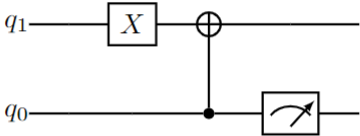

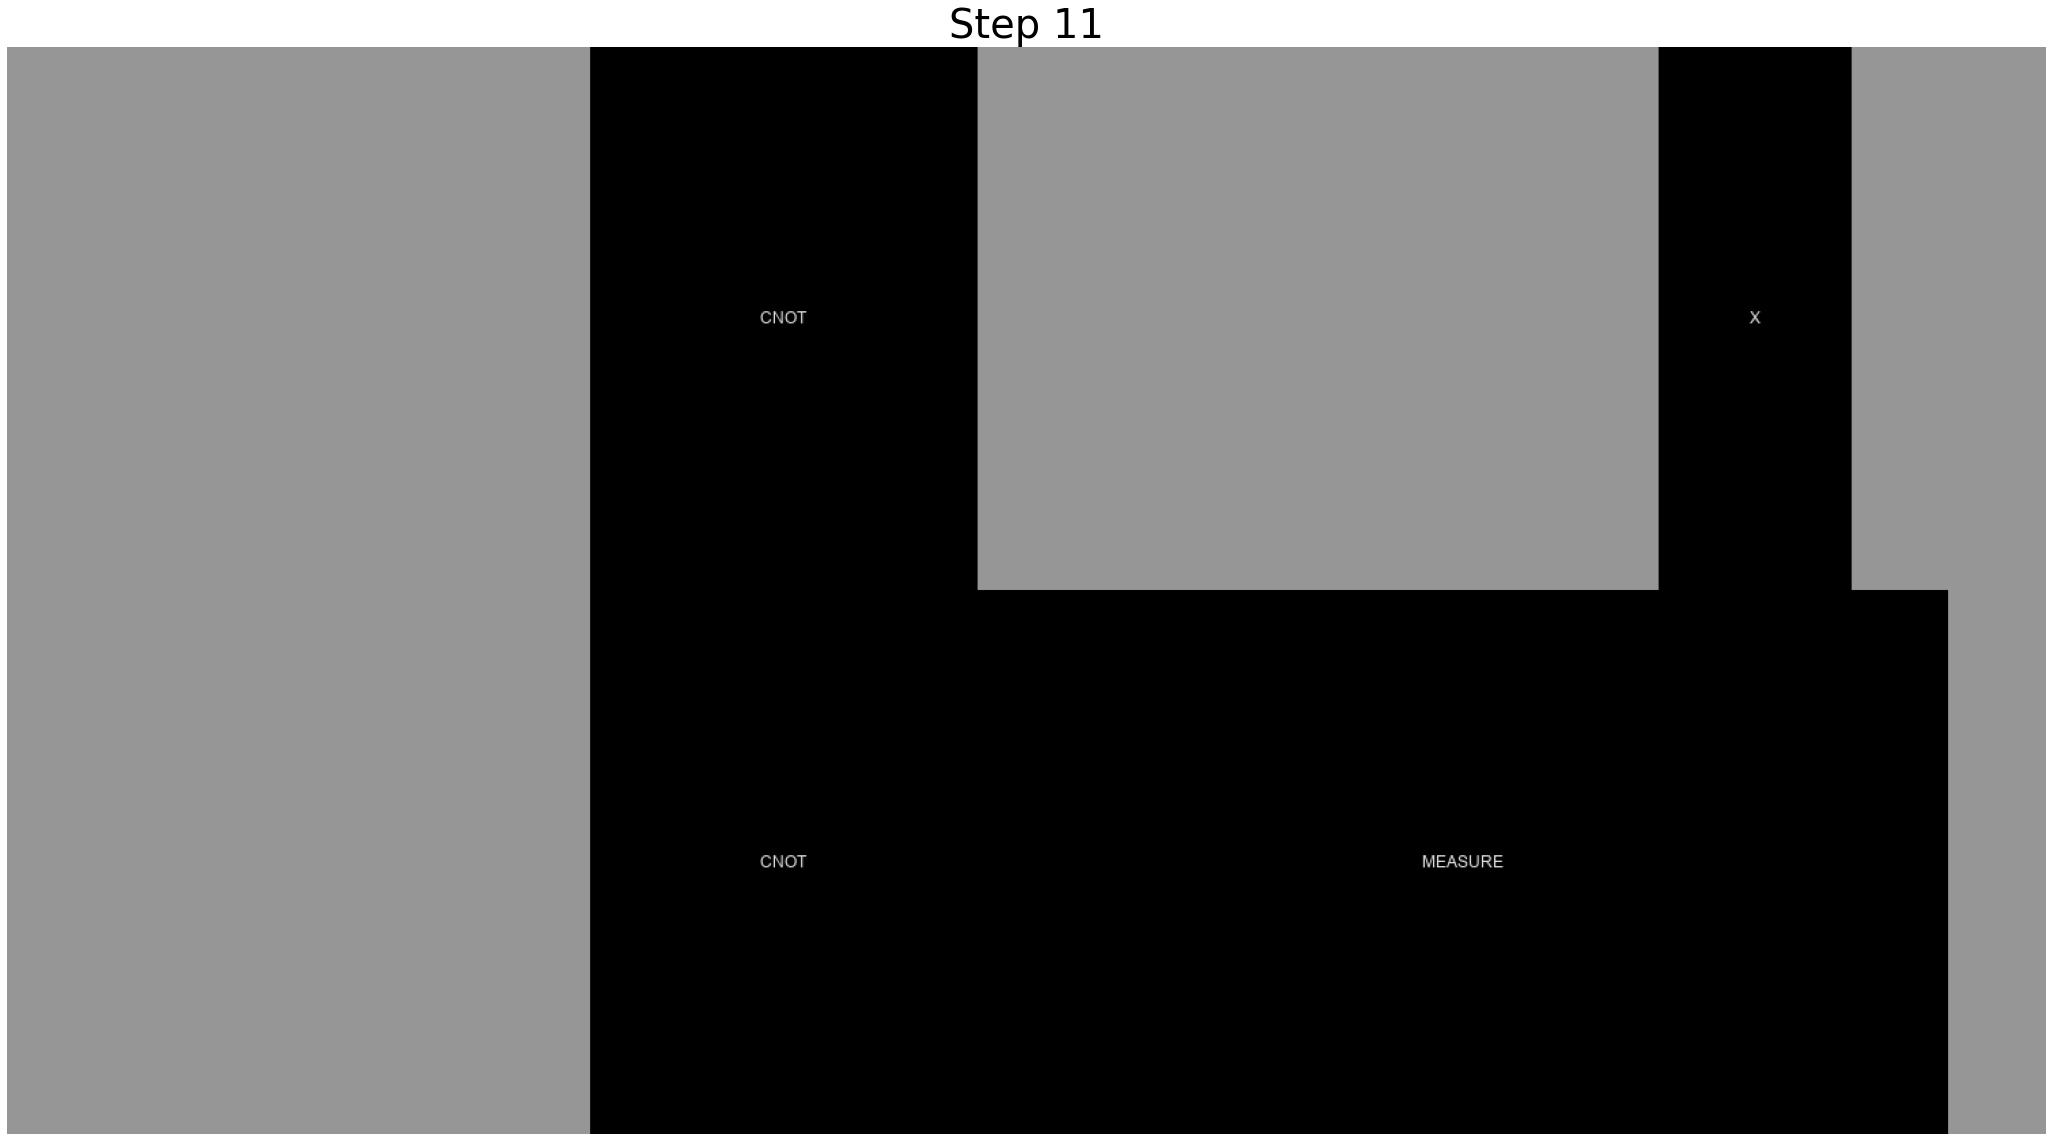

In [45]:
circuit = [Gate("x", 1, 1), Gate("cnot", 0, 1), Gate("measure", 0, 0)] 
obs = env_com.reset(circuit = circuit)
for i in range(1000):
    action, states = model.predict(obs, deterministic=False)
    obs, rewards, done, info = env_com.step(action)
    render_rgb(i, env_com.render(mode="rgb_array"))
    if done:
        break

{'gate_names': array([1, 3, 4, 0, 0]), 'acts_on': array([1, 0, 0, 0, 0, 1, 1, 0, 0, 0]), 'dependencies': array([0, 2, 0, 0, 0]), 'legal_actions': array([ True, False,  True, False, False])}
